In [1]:
import xarray as xr
import glob
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.375
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import os
import sys

# Step 1: Add parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "/scratch/ivyglade/pdo/"))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Step 2: Now you can import file.py
import pdo_functions  # assuming file.py contains functions/classes

import importlib
importlib.reload(pdo_functions)
import numpy as np

In [2]:
cape_file_list = sorted(glob.glob('/hurrell-scratch2/ivyglade/pdo/CESM2LE/CAPE/wrf_cape_2d.LE2-*.1850-2014.nc'))

sst_file_list = sorted(glob.glob('/hurrell-scratch2/ivyglade/pdo/CESM2LE/SST/b.e21.BHISTcmip6.f09_g17.LE2*.pop.h.SST.185001-185912.nc'))

# Extract ensemble member ID using regex
ids = [re.search(r'LE2-\d{4}\.\d{3}', f).group(0) for f in cape_file_list]
# sst_ids = [re.search(r'LE2-\d{4}\.\d{3}', f).group(0) for f in sst_file_list]

In [3]:
test = xr.open_mfdataset(cape_file_list, combine='nested', concat_dim='ens')['mcape']

In [4]:
# Resample to MAM mean
test_monthly = test.resample(time='YE').mean().load()

In [5]:
# Detrend by removing the ensemble mean
test_monthly_de = test_monthly - test_monthly.mean(dim='ens')

In [6]:
# detrend
test_monthly_poly = pdo_functions.detrend_dim(test_monthly, 'time', 2).load()

In [33]:
# Open pdo
pdo = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/CESM2LE/cesm2_le_pdo_index.nc')['__xarray_dataarray_variable__'].load()

In [34]:
# subset MAM
pdo_mam = pdo.sel(time=pdo.time.dt.month.isin([3, 4, 5])).resample(time='YE').mean()

In [35]:
pdo_mam['time'] = test_monthly_de['time']
pdo_mam['ens'] = test_monthly_de['ens']

In [36]:
# Composite
pos_pdo_de = np.zeros((50, 165, 27, 48))
neg_pdo_de = np.zeros((50, 165, 27, 48))
pos_pdo_poly = np.zeros((50, 165, 27, 48))
neg_pdo_poly = np.zeros((50, 165, 27, 48))
for i in range(50):
    pos_pdo_de[i] = xr.where(pdo_mam[i] > 0, test_monthly_de[i], np.nan)
    neg_pdo_de[i] = xr.where(pdo_mam[i] < 0, test_monthly_de[i], np.nan)
    pos_pdo_poly[i] = xr.where(pdo_mam[i] > 0, test_monthly_poly[i], np.nan)
    neg_pdo_poly[i] = xr.where(pdo_mam[i] < 0, test_monthly_poly[i], np.nan)

In [38]:
np.nanmean(pos_pdo_poly, axis=(0, 1)).min()

-30.527838087647666

In [37]:
np.nanmean(pos_pdo_de, axis=(0, 1)).min()

-26.127917979451066

In [39]:
# Land mask
land_110 = regionmask.defined_regions.natural_earth_v4_1_0.land_110
land = xr.where(land_110.mask_3D(test_monthly, lon_name='lon', lat_name='lat')==True, 1, np.nan).squeeze()

/scratch/ivyglade/miniconda3/envs/myenv_py39/lib/python3.9/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


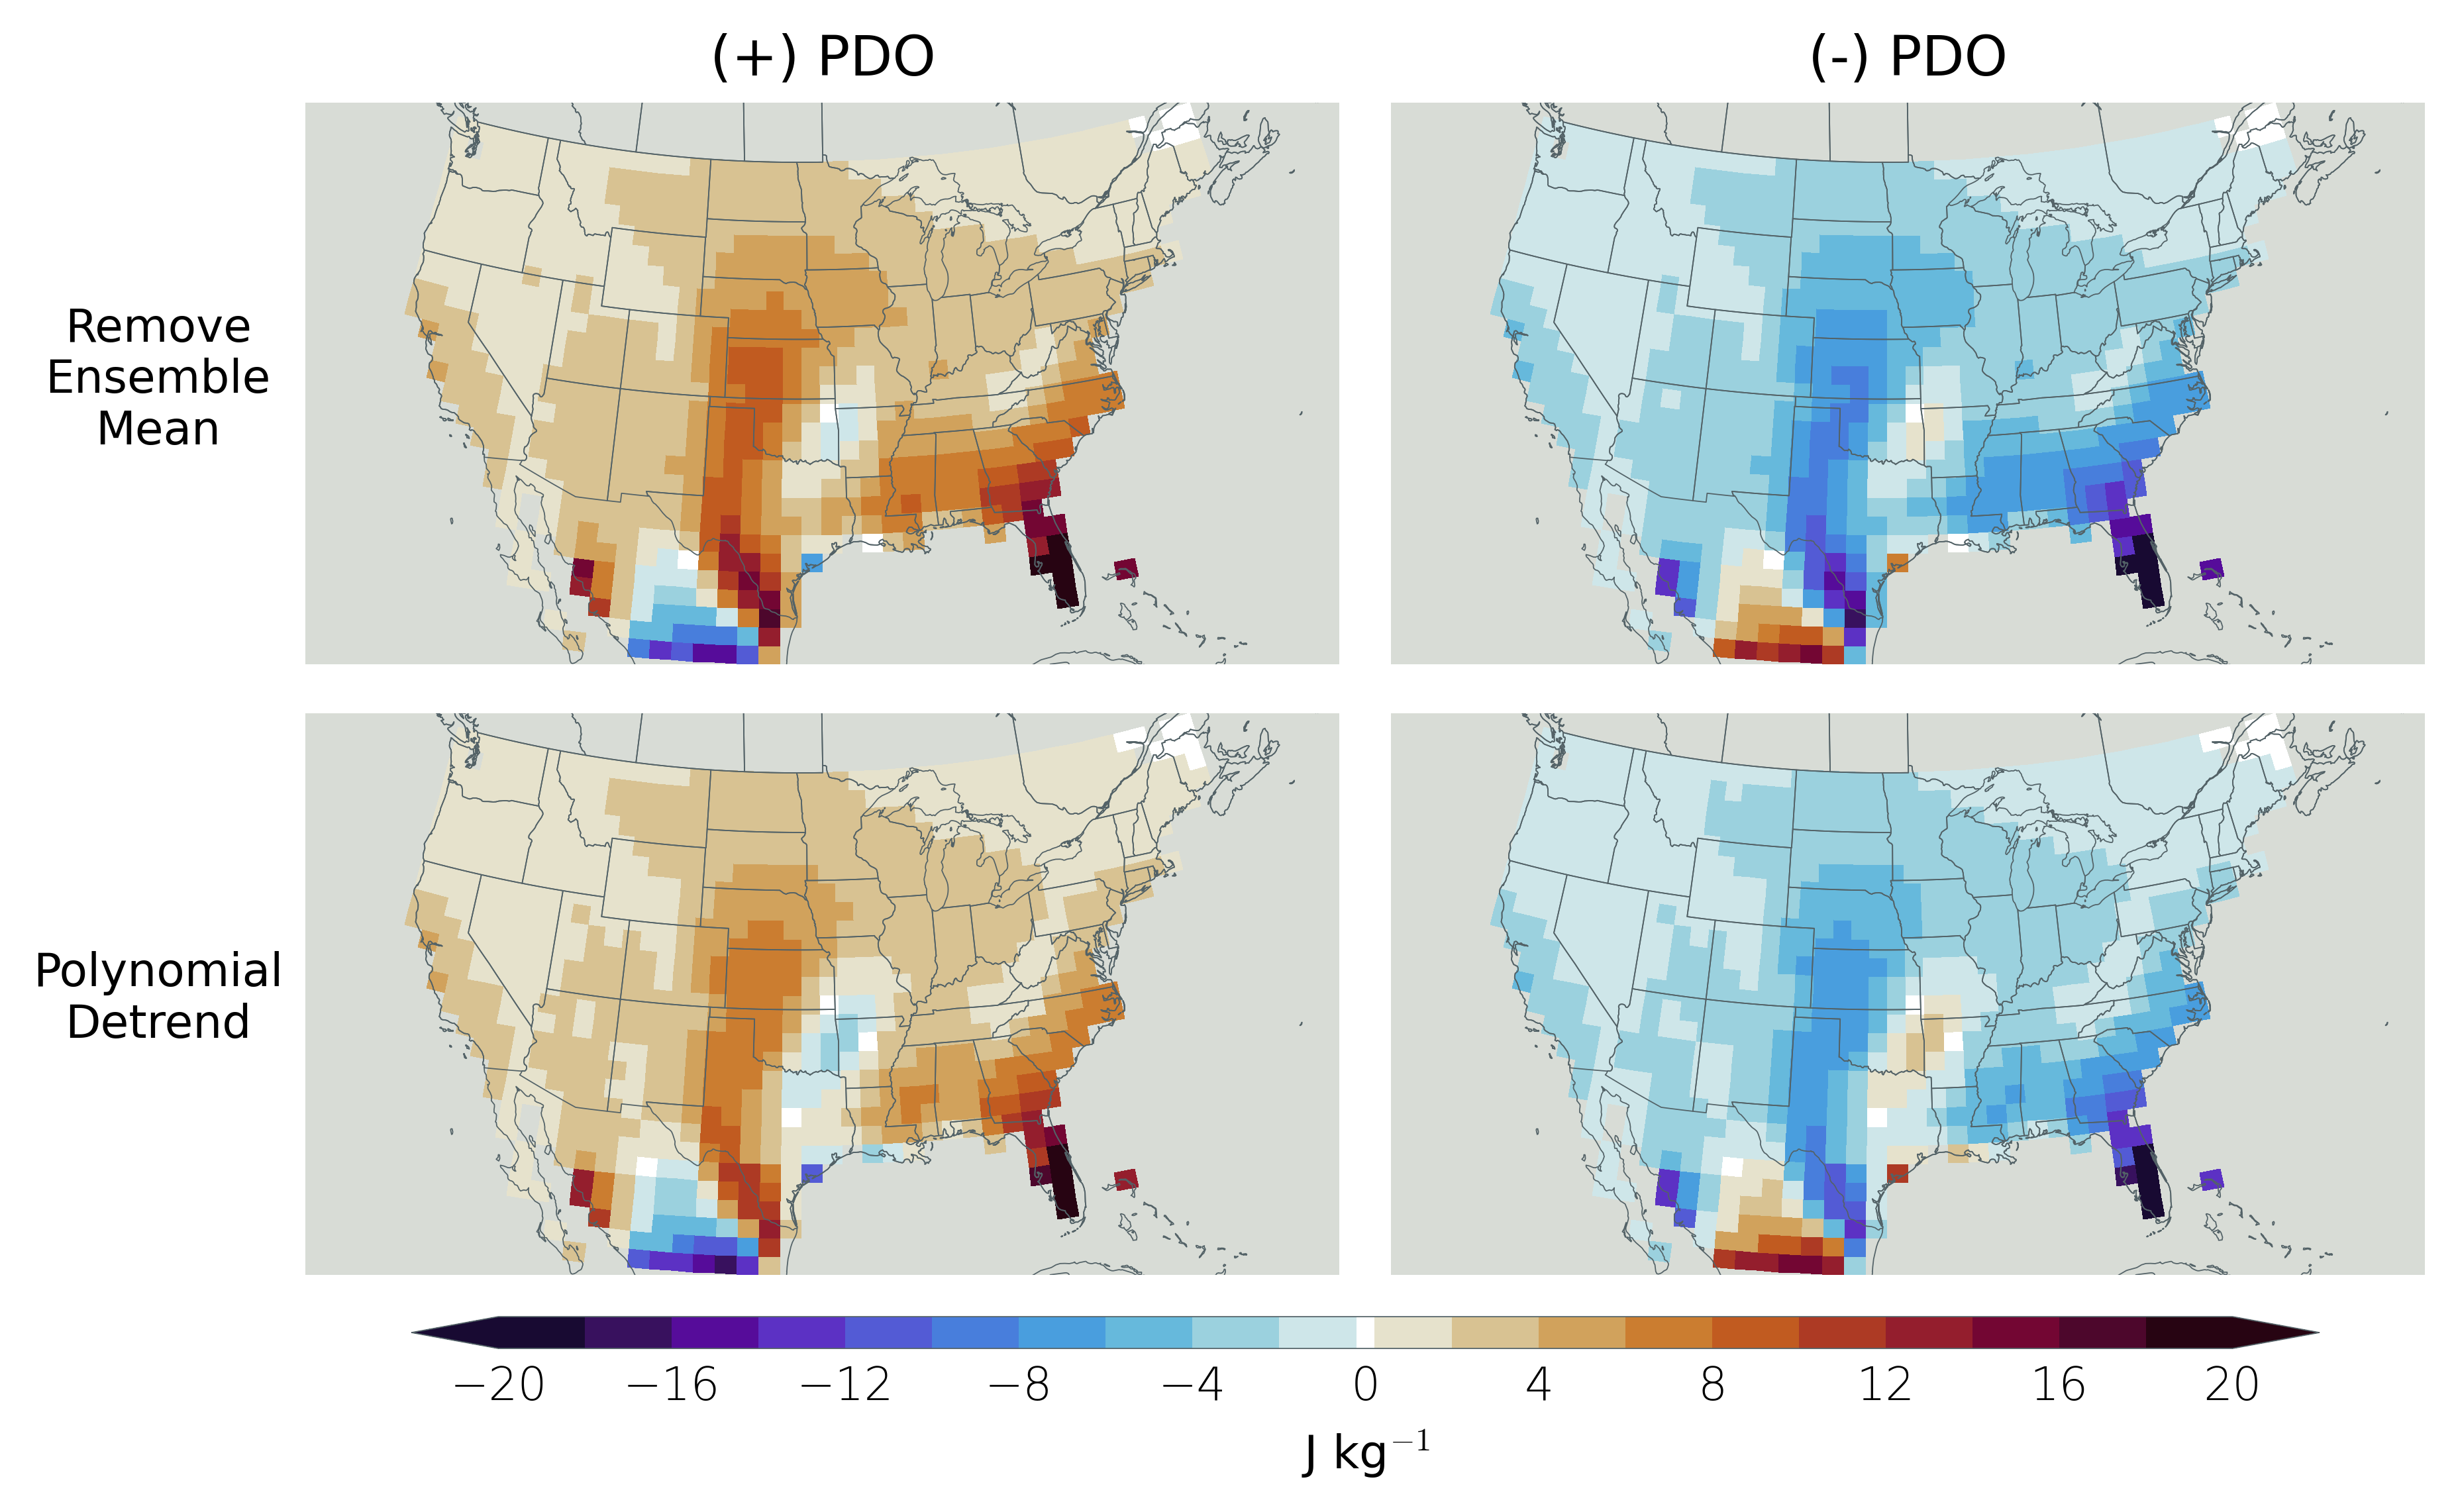

In [57]:
fig, ax = plt.subplots(2, 2, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], \
      ax[1, 0], ax[1, 1]]

bounds = [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, -0.2, 0.2, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

norm = c.BoundaryNorm(bounds, plt.get_cmap('cmr.fusion_r').N)

for i in range(4):
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0)
    ax[i].set_facecolor('xkcd:light gray')
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')

ax[0].pcolormesh(test_monthly_de['lon'], test_monthly_de['lat'], np.nanmean(pos_pdo_de, axis=(0, 1))*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)  
ax[1].pcolormesh(test_monthly_de['lon'], test_monthly_de['lat'], np.nanmean(neg_pdo_de, axis=(0, 1))*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)  

ax[2].pcolormesh(test_monthly_de['lon'], test_monthly_de['lat'], np.nanmean(pos_pdo_poly, axis=(0, 1))*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)  
ax[3].pcolormesh(test_monthly_de['lon'], test_monthly_de['lat'], np.nanmean(neg_pdo_poly, axis=(0, 1))*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)  

cax = plt.axes([0.05, .21, 0.9, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                   ticks=[-20, -16, -12, -8, -4, 0, 4, 8, 12, 16, 20])
cbar.set_label(r'J kg$^{-1}$', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.25)
cbar.outline.set_color('xkcd:gunmetal')
# cbar.outline.set_visible(False)

ax[0].set_title('(+) PDO')
ax[1].set_title('(-) PDO')

ax[0].text(-3700000, -200000, f"Remove\nEnsemble\nMean", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[2].text(-3700000, -100000, f"Polynomial\nDetrend", fontweight='normal', size=10, rotation='horizontal', ha='center')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=1., 
                    wspace=0.05, 
                    hspace=0.05)

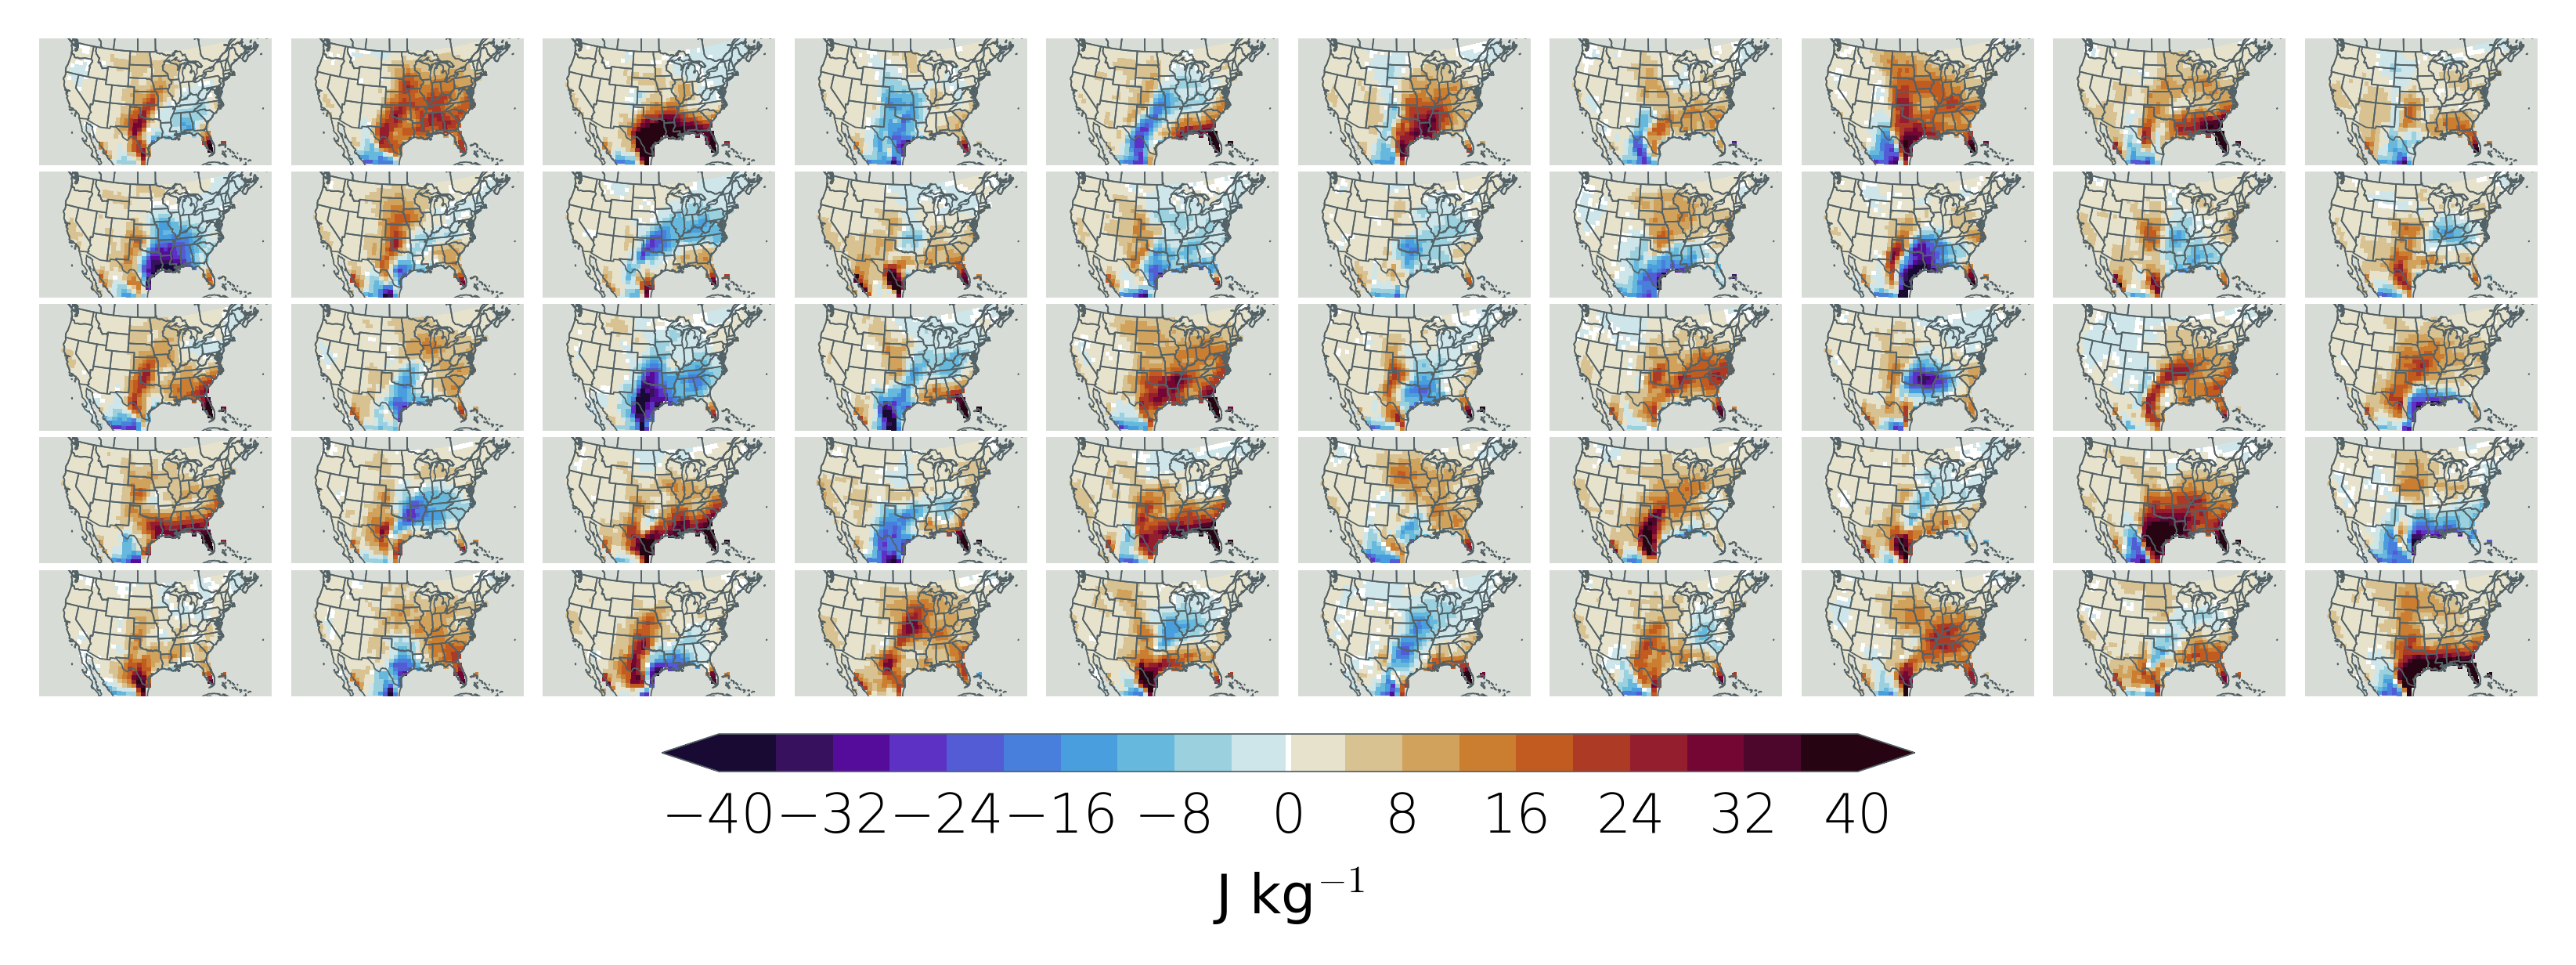

In [66]:
fig, ax = plt.subplots(5, 10, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

bounds = [-40, -36, -32, -28, -24, -20, -16, -12, -8, -4, -0.2, 0.2, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40]

norm = c.BoundaryNorm(bounds, plt.get_cmap('cmr.fusion_r').N)

ax = [ax[0, 0], ax[0, 1], ax[0, 2], ax[0, 3], ax[0, 4], ax[0, 5], ax[0, 6], ax[0, 7], ax[0, 8], ax[0, 9], \
      ax[1, 0], ax[1, 1], ax[1, 2], ax[1, 3], ax[1, 4], ax[1, 5], ax[1, 6], ax[1, 7], ax[1, 8], ax[1, 9],\
      ax[2, 0], ax[2, 1], ax[2, 2], ax[2, 3], ax[2, 4], ax[2, 5], ax[2, 6], ax[2, 7], ax[2, 8], ax[2, 9],\
      ax[3, 0], ax[3, 1], ax[3, 2], ax[3, 3], ax[3, 4], ax[3, 5], ax[3, 6], ax[3, 7], ax[3, 8], ax[3, 9],\
      ax[4, 0], ax[4, 1], ax[4, 2], ax[4, 3], ax[4, 4], ax[4, 5], ax[4, 6], ax[4, 7], ax[4, 8], ax[4, 9],]

for i in range(50):
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0)
    ax[i].set_facecolor('xkcd:light gray')
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].pcolormesh(test_monthly_de['lon'], test_monthly_de['lat'], np.nanmean(pos_pdo_de[i], axis=(0))*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)  

cax = plt.axes([0.25, .21, 0.5, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                   ticks=[-40, -32, -24, -16, -8, 0, 8, 16, 24, 32, 40])
cbar.set_label(r'J kg$^{-1}$', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.25)
cbar.outline.set_color('xkcd:gunmetal')
# cbar.outline.set_visible(False)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.6, 
                    wspace=0.05, 
                    hspace=0.05)

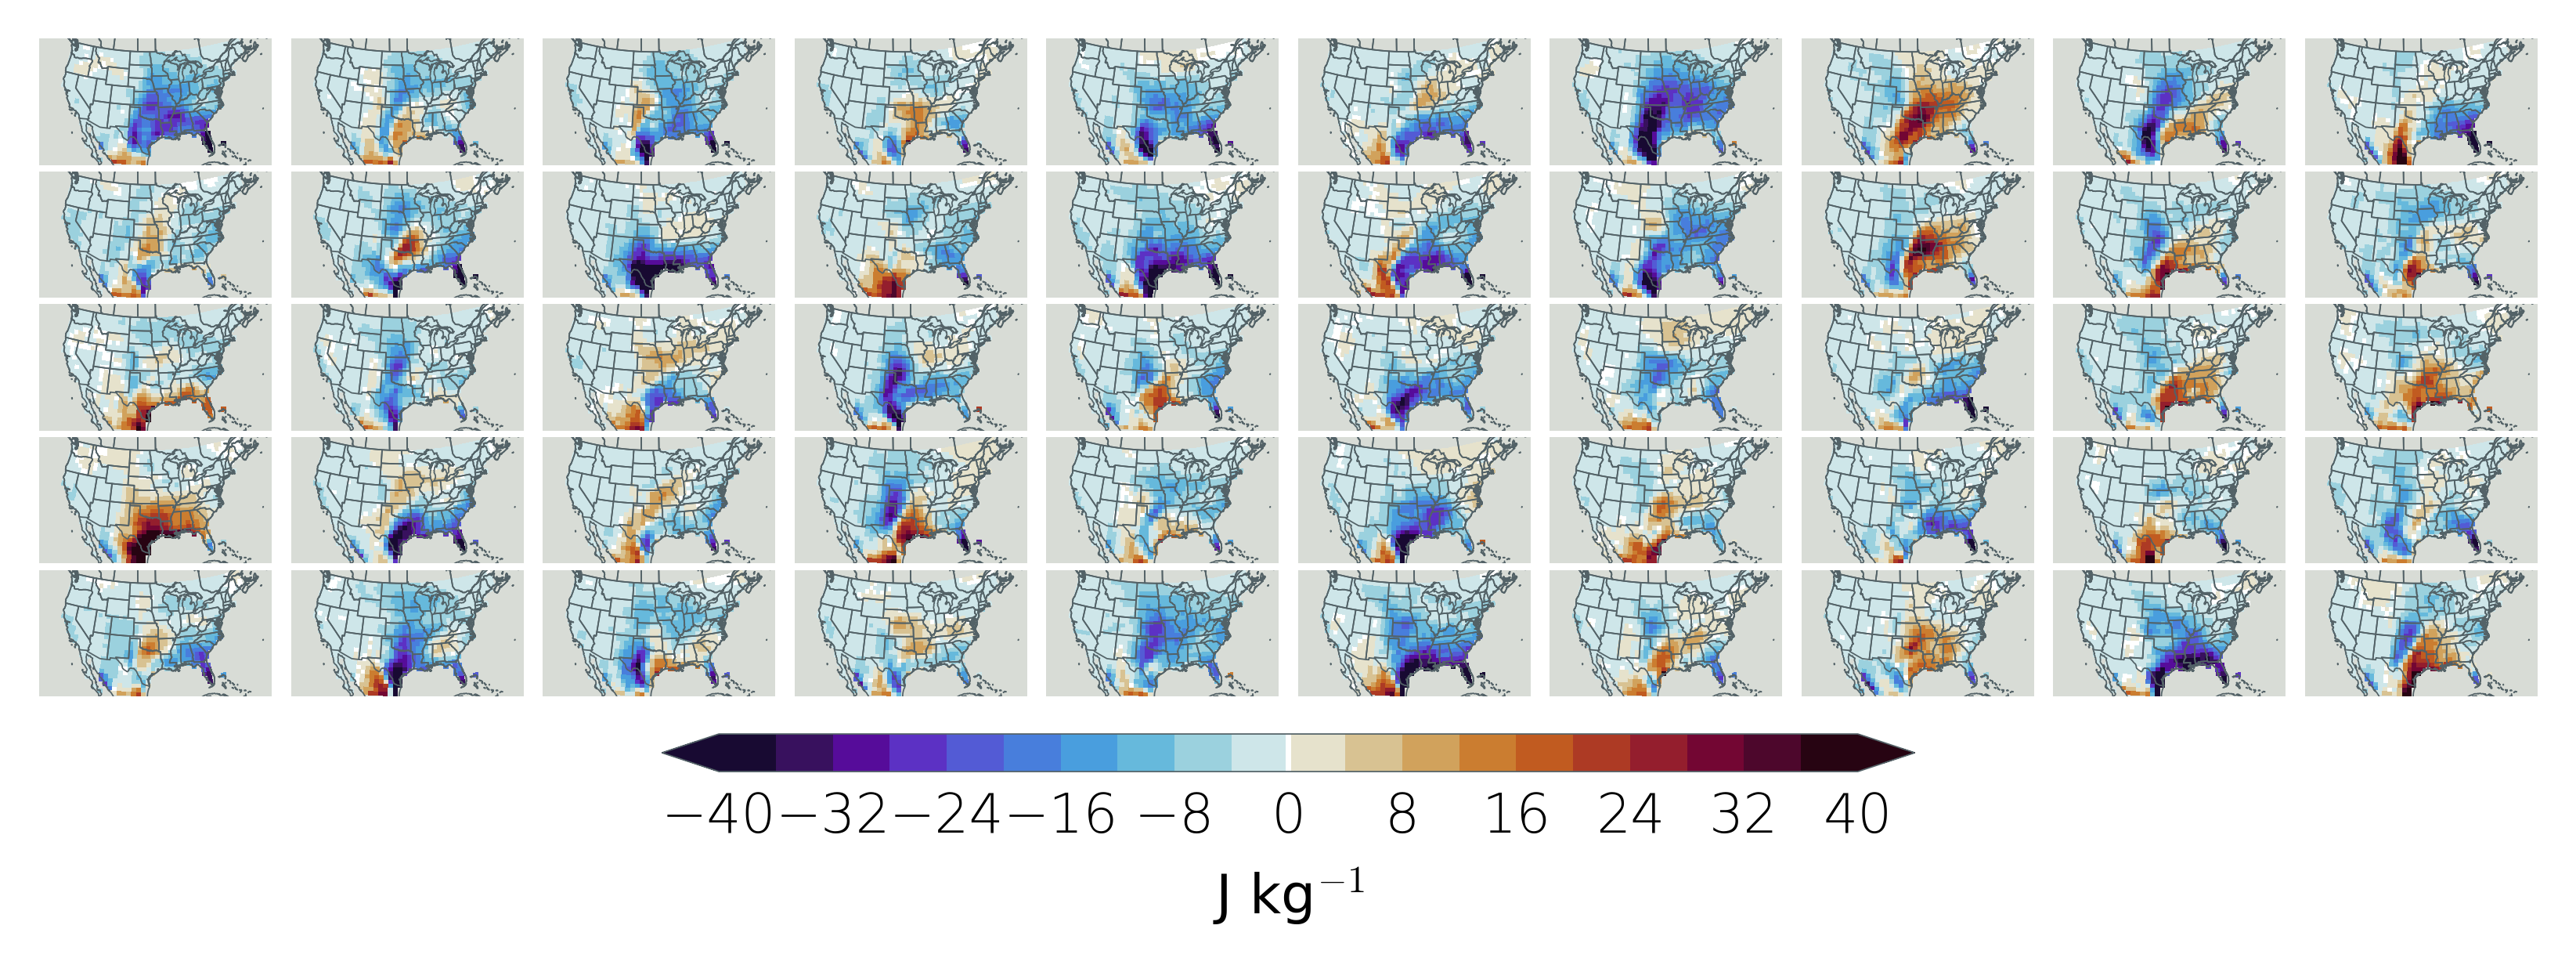

In [68]:
fig, ax = plt.subplots(5, 10, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

bounds = [-40, -36, -32, -28, -24, -20, -16, -12, -8, -4, -0.2, 0.2, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40]

norm = c.BoundaryNorm(bounds, plt.get_cmap('cmr.fusion_r').N)

ax = [ax[0, 0], ax[0, 1], ax[0, 2], ax[0, 3], ax[0, 4], ax[0, 5], ax[0, 6], ax[0, 7], ax[0, 8], ax[0, 9], \
      ax[1, 0], ax[1, 1], ax[1, 2], ax[1, 3], ax[1, 4], ax[1, 5], ax[1, 6], ax[1, 7], ax[1, 8], ax[1, 9], \
      ax[2, 0], ax[2, 1], ax[2, 2], ax[2, 3], ax[2, 4], ax[2, 5], ax[2, 6], ax[2, 7], ax[2, 8], ax[2, 9], \
      ax[3, 0], ax[3, 1], ax[3, 2], ax[3, 3], ax[3, 4], ax[3, 5], ax[3, 6], ax[3, 7], ax[3, 8], ax[3, 9], \
      ax[4, 0], ax[4, 1], ax[4, 2], ax[4, 3], ax[4, 4], ax[4, 5], ax[4, 6], ax[4, 7], ax[4, 8], ax[4, 9],]

for i in range(50):
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0)
    ax[i].set_facecolor('xkcd:light gray')
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].pcolormesh(test_monthly_de['lon'], test_monthly_de['lat'], np.nanmean(neg_pdo_de[i], axis=(0))*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)

cax = plt.axes([0.25, .21, 0.5, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                   ticks=[-40, -32, -24, -16, -8, 0, 8, 16, 24, 32, 40])
cbar.set_label(r'J kg$^{-1}$', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.25)
cbar.outline.set_color('xkcd:gunmetal')
# cbar.outline.set_visible(False)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.6, 
                    wspace=0.05, 
                    hspace=0.05)